<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Sales Forecasting

### Part 2 SKtime Models

---


## Contents:
- [Gather Data](#Gather-Data)
- [Plot the timeseries data](#Plot-the-timeseries-data)
- [Train/Test split](#Split-Data-into-Train/Test)
- [Naive Approach](#Naive-Approach)
- [Seasonal Naive](#Seasonal-Naive)
- [Exponential Smoothing](#ExponentialSmoothing)
- [AutoETS](#AutoETS-(Exponential-Smoothing-of-State-Space-Model))
- [Auto ARIMA](#Auto-ARIMA(Autoregressive-Integrated-Moving-Average))
- [BATS](#BATS)
- [TBATS](#TBATS-(Trigonometric-seasonality,-Box-Cox-transformation,-ARMA-errors,-Trend-and-Seasonal-components))
- [ThetaForecaster](#ThetaForecaster)
- [Prophet](#Prophet)
- [Random Forest](#Random-Forest)
- [XGBRRegressor and LGBMRegressor](#XGBRRegressor-and-LGBMRegressor)
- [SKtime-Ensembler](#SKtime-Ensembler)
- [Compare Different Models SMAPE Score](#Compare-Different-Models-SMAPE-Score)

## Import Libraries

In [221]:
from warnings import simplefilter

import numpy as np
import pandas as pd

from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.bats import BATS
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    ReducedForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.utils.plotting import plot_series
from sktime.forecasting.fbprophet import Prophet
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import pickle
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

simplefilter("ignore", FutureWarning)
%matplotlib inline

## Gather Data

In [222]:
#Import Sales data
sales=pd.read_csv('../Dataset/sales_df.csv')
sales.date= pd.to_datetime(sales.date)
sales = sales.set_index('date')
sales.head()

,total_sales
date,
2011-01-29,32631.0
2011-01-30,31749.0
2011-01-31,23783.0
2011-02-01,25412.0
2011-02-02,19146.0


In [223]:
#Get the timeseries 
y=sales['total_sales']
z=y.copy()

In [224]:
#Convert y.index to PeriodIndex for plot_series
y.index=y.index.to_period("D")

In [225]:
#z.index as DatetimeIndex for prophet
z.index

DatetimeIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07',
               ...
               '2016-05-13', '2016-05-14', '2016-05-15', '2016-05-16',
               '2016-05-17', '2016-05-18', '2016-05-19', '2016-05-20',
               '2016-05-21', '2016-05-22'],
              dtype='datetime64[ns]', name='date', length=1941, freq=None)

## Plot the timeseries data

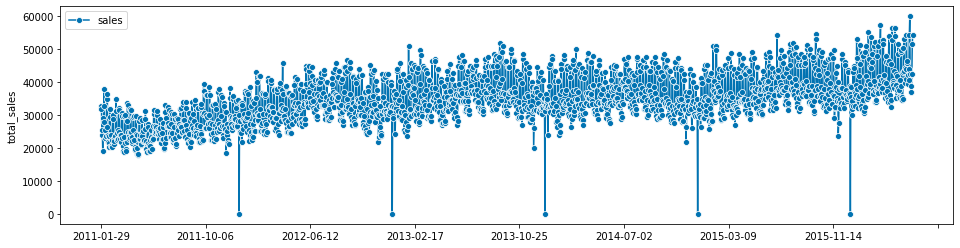

In [226]:
y=sales['total_sales']
plot_series(y, labels=['sales']);

## Import calendar data

In [227]:
cal=pd.read_csv('../Dataset/calendar.csv')

In [228]:
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


## Split Data into Train/Test

1913 28


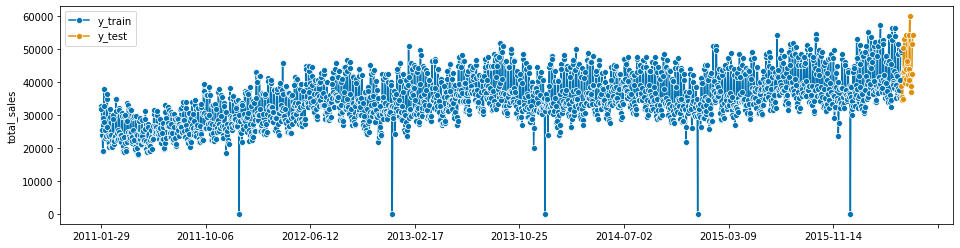

In [229]:
#Split data into train and test and plot.
y_train, y_test = temporal_train_test_split(y, test_size=28)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

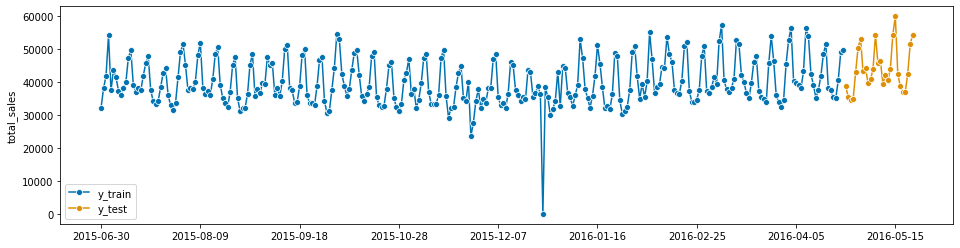

In [230]:
#Zoom into to see the seasonality of data.
plot_series(y_train[-300:], y_test, labels=["y_train", "y_test"]);

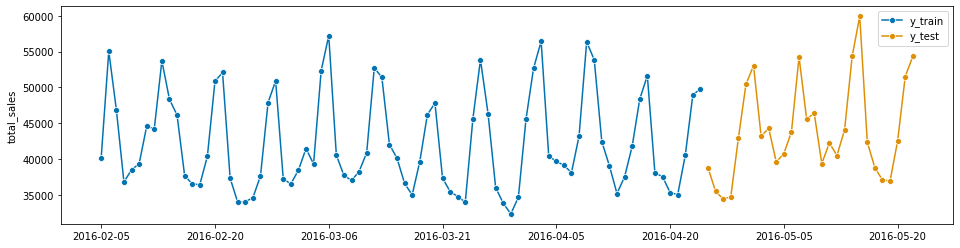

In [231]:
#Zoom into to see the seasonality of data.
plot_series(y_train[-80:], y_test, labels=["y_train", "y_test"]);

In [232]:
# fh = np.arange(len(y_test)) + 1
# fh

In [233]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2016-04-25', '2016-04-26', '2016-04-27', '2016-04-28',
             '2016-04-29', '2016-04-30', '2016-05-01', '2016-05-02',
             '2016-05-03', '2016-05-04', '2016-05-05', '2016-05-06',
             '2016-05-07', '2016-05-08', '2016-05-09', '2016-05-10',
             '2016-05-11', '2016-05-12', '2016-05-13', '2016-05-14',
             '2016-05-15', '2016-05-16', '2016-05-17', '2016-05-18',
             '2016-05-19', '2016-05-20', '2016-05-21', '2016-05-22'],
            dtype='period[D]', name='date', freq='D', is_relative=False)

## Save and open each models

In [234]:
# save the model
def save_model(model_name):
    #print(model_name)
    filename = '../Models/'+str(model_name)+'.pkl'
    pickle.dump(model_name, open(filename, 'wb'))

In [235]:
result=pd.DataFrame(columns=['model', 'smape_loss'])

In [236]:
def load_model(model_name, y_train, y_test, y_prediction):
    filename = '../Models/'+str(model_name)+'.pkl'
    loaded_model = pickle.load(open(filename, 'rb'))
    plot_series(y_train[-40:], y_test, y_prediction, labels=["y_train", "y_test", "y_pred_"+str(model_name)])
    result=smape_loss(y_test, y_prediction)
    return result

## Modelling

## Naive Approach

Naive model is the baseline model which predict the last value over the whole forecasting horizon.

,model,smape_loss
1,naive,0.173581


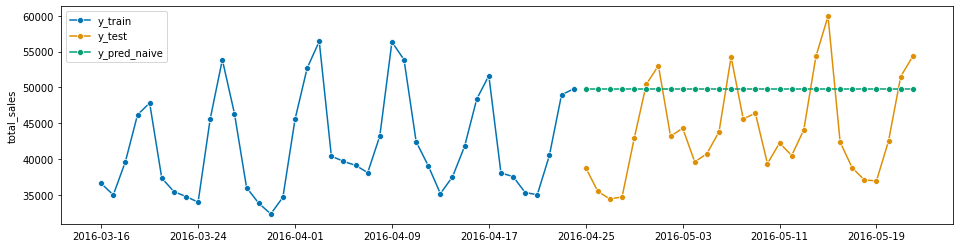

In [237]:
# using sktime Naive
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred_naive = forecaster.predict(fh)

#Save model
save_model('naive')

#Plot and calculate SMAPE loss
loss_naive=load_model('naive', y_train, y_test, y_pred_naive)

#Save and display model name with SMAPE loss
myindex = result.shape[0]+1 
result.at[myindex,'model']='naive'
result.at[myindex,'smape_loss']=loss_naive
result[result['model']=="naive"]

## Seasonal Naive

Seasonal Naive model predicts the last season over the whole whole forecasting horizon. 

Wall time: 119 ms


,model,smape_loss
2,naive_last_season,0.087535


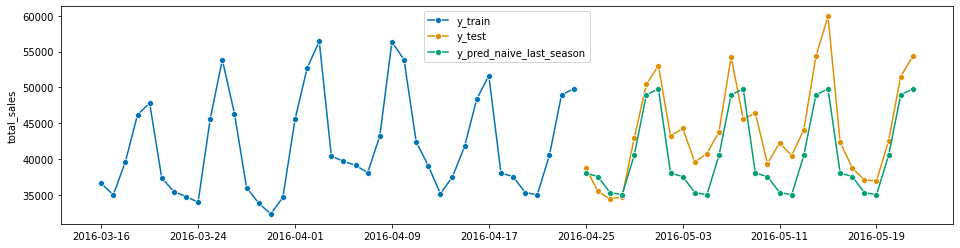

In [238]:
%%time
#Seasonal Naive
forecaster = NaiveForecaster(strategy="last", sp=7)
forecaster.fit(y_train)
y_pred_last_season = forecaster.predict(fh)

#Save model
save_model('naive_last_season')

#Plot and calculate SMAPE loss
loss_naive_last_season=load_model('naive_last_season', y_train, y_test, y_pred_last_season)


#Save and display model name with SMAPE loss 
myindex = result.shape[0]+1 
result.at[myindex,'model']='naive_last_season'
result.at[myindex,'smape_loss']=loss_naive_last_season
result[result['model']=='naive_last_season']

## Exponential Smoothing

The previous time steps are exponentially weighted and added up to generate the forecast. The weights decay as we move further backwards in time. 

Wall time: 553 ms


C:\Users\fast6\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



,model,smape_loss
3,exponential,0.08931


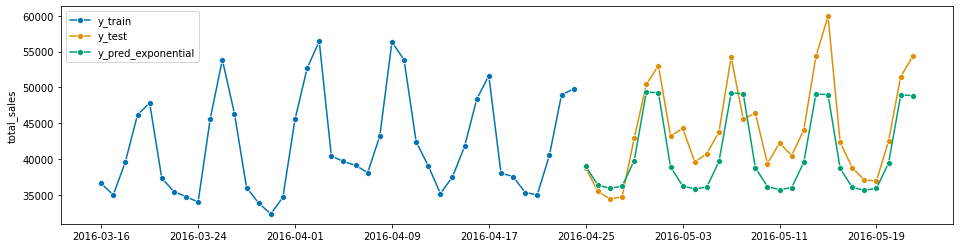

In [239]:
%%time

forecaster = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=7)
forecaster.fit(y_train)
y_pred_exponential = forecaster.predict(fh)

#Save model
save_model('exponential')

#Plot and calculate SMAPE loss
loss_exponential=load_model('exponential', y_train, y_test, y_pred_exponential)

#Save and display model name with SMAPE loss
myindex = result.shape[0]+1 
result.at[myindex,'model']='exponential'
result.at[myindex,'smape_loss']=loss_exponential
result[result['model']=='exponential']

## AutoETS (Exponential Smoothing of State Space Model)

The methodology is fully automatic. The only required argument for ets is the time series.

Wall time: 1.35 s


,model,smape_loss
4,auto_ets,0.081176


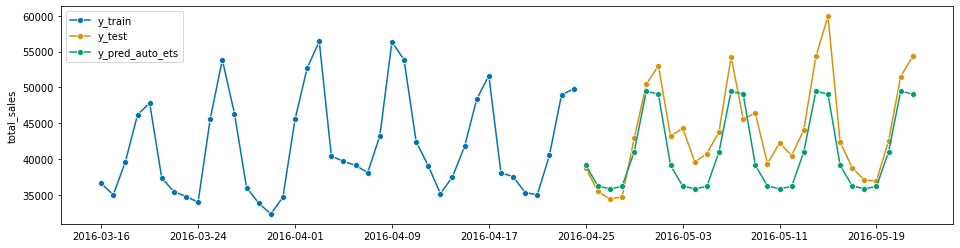

In [240]:
%%time

forecaster = AutoETS(auto=True, sp=7, n_jobs=-1)
forecaster.fit(y_train)
y_pred_auto_ets = forecaster.predict(fh)

#Save model
save_model('auto_ets')

#Plot and calculate SMAPE loss
loss_auto_ets=load_model('auto_ets', y_train, y_test, y_pred_auto_ets)

#Save and display model name with SMAPE loss
myindex = result.shape[0]+1 
result.at[myindex,'model']='auto_ets'
result.at[myindex,'smape_loss']=loss_auto_ets
result[result['model']=='auto_ets']

## Auto ARIMA(Autoregressive Integrated Moving Average)

ARIMA stands for Auto Regressive Integrated Moving Average. While exponential smoothing models were based on a description of trend and seasonality in data, ARIMA models aim to describe the correlations in the time series. Auto Arima automatically select the best ARIMA model. 

Wall time: 1min 1s


,model,smape_loss
5,autoarima,0.571929


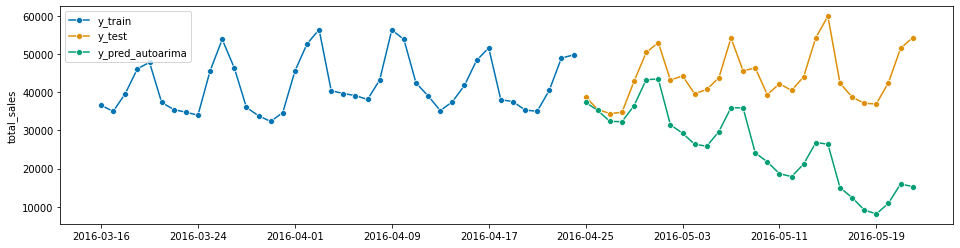

In [241]:
%%time

forecaster = AutoARIMA(sp=7, suppress_warnings=True)
forecaster.fit(y_train)
y_pred_autoarima = forecaster.predict(fh)

#Save model
save_model('autoarima')

#Plot and calculate SMAPE loss
loss_autoarima=load_model('autoarima', y_train, y_test, y_pred_autoarima)

#Save and display model name with SMAPE loss
myindex = result.shape[0]+1 
result.at[myindex,'model']='autoarima'
result.at[myindex,'smape_loss']=loss_autoarima
result[result['model']=='autoarima']

## BATS(Exponential smoothing state space model with Box-Cox transformation, ARMA errors, Trend and Seasonal components)

BATS is for Exponential smoothing state space model with Box-Cox transformation, ARMA errors, Trend and Seasonal components. Box Cox transformation is a transformation of a non-normal dependent variables into a normal shape. BATS fits the best performing model.

Wall time: 1min 7s


,model,smape_loss
6,bats,0.070344


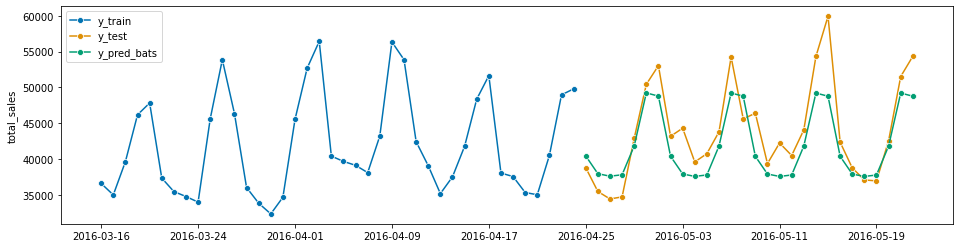

In [242]:
%%time

forecaster = BATS(sp=7, use_trend=True, use_box_cox=False)
forecaster.fit(y_train)
y_pred_bats = forecaster.predict(fh)

#Save model
save_model('bats')

#Plot and calculate SMAPE loss
loss_bats= load_model('bats', y_train, y_test, y_pred_bats)

#Save and display model name with SMAPE loss
myindex = result.shape[0]+1 
result.at[myindex,'model']='bats'
result.at[myindex,'smape_loss']=loss_bats
result[result['model']=='bats']

## TBATS (Exponential smoothing state space model with Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend and Seasonal components)

TBATS stands for Exponential smoothing state space model with Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend and Seasonal components. Each seasonality is modeled by a trigonometric representation based on Fourier series.

Wall time: 4min 11s


,model,smape_loss
7,tbats,0.072434


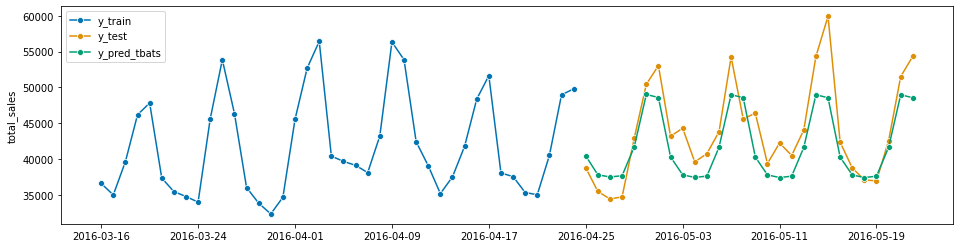

In [243]:
%%time

forecaster = TBATS(sp=7, use_trend=True, use_box_cox=False)
forecaster.fit(y_train)
y_pred_tbats = forecaster.predict(fh)

#Save model
save_model('tbats')

#Plot and calculate SMAPE loss
loss_tbats=load_model('tbats', y_train, y_test, y_pred_tbats)

#Save and display model name with SMAPE loss 
myindex = result.shape[0]+1 
result.at[myindex,'model']='tbats'
result.at[myindex,'smape_loss']=loss_tbats
result[result['model']=='tbats']

## ThetaForecaster

ThetaForecaster is equivalent to simple exponential smoothing(SES) with drift. 

Wall time: 138 ms


,model,smape_loss
8,theta,0.080372


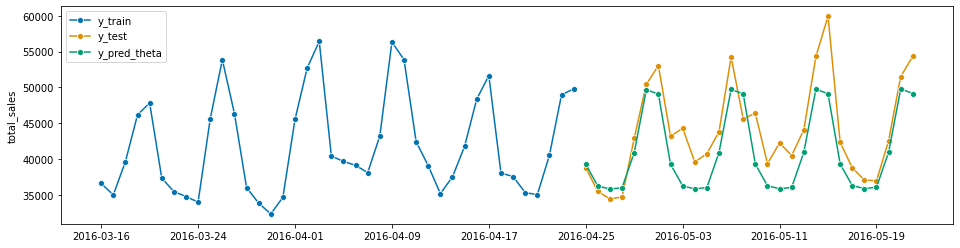

In [244]:
%%time

forecaster = ThetaForecaster(sp=7)
forecaster.fit(y_train)
y_pred_theta = forecaster.predict(fh)

#Save model
save_model('theta')

#Plot and calculate SMAPE loss
loss_theta=load_model('theta', y_train, y_test, y_pred_theta)

#Save and display model name with SMAPE loss
myindex = result.shape[0]+1 
result.at[myindex,'model']='theta'
result.at[myindex,'smape_loss']=loss_theta
result[result['model']=='theta']

## Prophet

Prophet is an opensource time series forecasting project by Facebook. It is based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, including holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data.

#### Get a list of holidays from Calendar.csv

In [245]:
#Get a list of holidays from Calendar.csv
def format_holidays(cal):
    df_ev_1 = pd.DataFrame({'holiday': 'Event 1', 'ds': cal[~cal['event_name_1'].isna()]['date']})
    df_ev_2 = pd.DataFrame({'holiday': 'Event 2', 'ds': cal[~cal['event_name_2'].isna()]['date']})
    df_ev_3 = pd.DataFrame({'holiday': 'snap_CA', 'ds': cal[cal['snap_CA'] == 1]['date']})
    df_ev_4 = pd.DataFrame({'holiday': 'snap_TX', 'ds': cal[cal['snap_TX'] == 1]['date']})
    df_ev_5 = pd.DataFrame({'holiday': 'snap_WI', 'ds': cal[cal['snap_WI'] == 1]['date']})
    holidays = pd.concat((df_ev_1, df_ev_2, df_ev_3, df_ev_4, df_ev_5))

    holidays['ds'] = pd.to_datetime(holidays['ds'])
    return holidays
holidays = format_holidays(cal)

#Save holidays into csv to be loaded into the next notebook
holidays.to_csv('../Dataset/holidays.csv')

### Preprocessing

In [246]:
# Convert index to pd.DatetimeIndex
z_train, z_test = temporal_train_test_split(z, test_size=28)

In [247]:
#y_train.reset_index()

In [248]:
#Change the data frequency to daily
z_test.index.freq='D'
z_train.index.freq='D'

In [249]:
#Forecasting horizon with dtype Datetime
fh_p = ForecastingHorizon(z_test.index, is_relative=False)

### Modelling

,model,smape_loss
9,prophet,0.031872


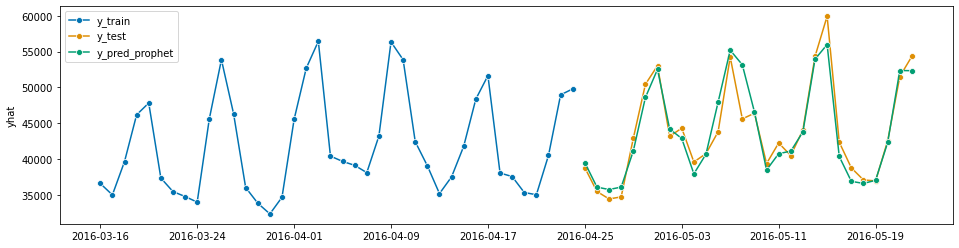

In [250]:
#Prophet
sk_forecaster2 = Prophet(seasonality_mode='multiplicative', 
                holidays=holidays,
                n_changepoints=2,
                changepoint_range=0.95,
                changepoint_prior_scale=0.1,
                seasonality_prior_scale=10,
                holidays_prior_scale=10,
                daily_seasonality=True, 
                weekly_seasonality=True,
                yearly_seasonality=True
                )

sk_forecaster2.fit(z_train)

#prediction
y_pred_prophet = sk_forecaster2.predict(fh_p)
y_pred_prophet.index = y_test.index

#Save model
save_model('prophet')

#Plot and calculate SMAPE loss
loss_prophet=load_model('prophet', y_train, y_test, y_pred_prophet)

#Save and display model name with SMAPE loss
myindex = result.shape[0]+1 
result.at[myindex,'model']='prophet'
result.at[myindex,'smape_loss']=loss_prophet
result[result['model']=='prophet']

## Random Forest

The Random Forest model is a bagging technique, which uses bootstrap sampling without replacement of every sample to train and it reduces variance while training and prevents from overfitting.

,model,smape_loss
10,r_forest,0.058013


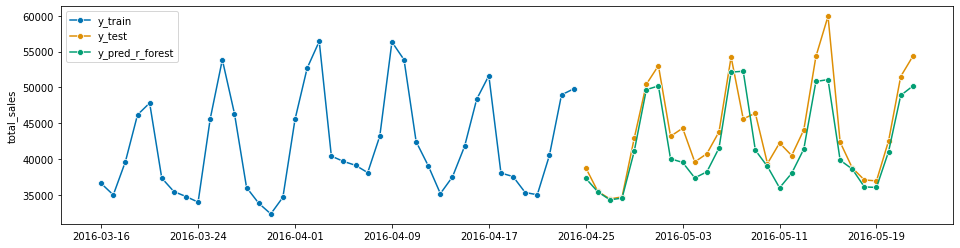

In [251]:
# tuning the 'n_estimator' hyperparameter of RandomForestRegressor from scikit-learn
regressor_param_grid = {"n_estimators": [100, 200]}
forecaster_param_grid = {"window_length": [40, 50, 60]}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(RandomForestRegressor(), param_grid=regressor_param_grid)
forecaster = ReducedForecaster(
    regressor, window_length=15, scitype='regressor',strategy="recursive"
)

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv_rf = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

gscv_rf.fit(y_train)
y_pred_rf = gscv_rf.predict(fh)

#Save model
save_model('r_forest')

#Plot and calculate SMAPE loss
loss_rf=load_model('r_forest', y_train, y_test, y_pred_rf)

#Save and display model name with SMAPE loss 
myindex = result.shape[0]+1 
result.at[myindex,'model']='r_forest'
result.at[myindex,'smape_loss']=loss_rf
result[result['model']=='r_forest']

In [257]:
#Print best params
print(gscv_rf.best_params_, gscv_rf.best_forecaster_.regressor_.best_params_)

{'window_length': 40} {'n_estimators': 100}


## XGBRRegressor and LGBMRegressor

### Compare default XGBRRegressor and LGBMRegressor

In [259]:
%%time
xgb = XGBRegressor()
lgb = LGBMRegressor()
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
param_grid = {
    "window_length": [x for x in range(26, 30, 2)],
    "regressor": [xgb, lgb]
}

forecaster = ReducedForecaster(regressor=xgb,scitype='regressor')
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid, scoring=sMAPE(),verbose=1)
gscv.fit(y_train)
results = pd.DataFrame(gscv.cv_results_)



Fitting 1913 folds for each of 4 candidates, totalling 7652 fits
Wall time: 1min 41s


gscv.best_params_

LGBMRegressor outperforms XGBRRegressor with default parameters

## LGBMRegressor

Light Gradient Boosting Regression is a boosting technique to reduce bias while training the model. It has faster training speed and higher efficiency. 

In [261]:
%%time

lgb = LGBMRegressor()
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))

#LGBM param grid
lgb_params_grid = {
    'num_leaves': [25, 40, 50],
    'learning_rate': [0.1, 0.01],
    'max_depth': [-1, 2, 5],
    'n_estimators': [40, 50, 100]
}

#GridsearchCV param grid
gscv_param_grid = {
    "window_length": [20, 67, 68]
}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(lgb, param_grid=lgb_params_grid)                         
forecaster = ReducedForecaster(regressor,scitype='regressor')

lgb_gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=gscv_param_grid, scoring=sMAPE())
lgb_gscv.fit(y_train)
lgb_results = pd.DataFrame(lgb_gscv.cv_results_)

Wall time: 3min 12s


ForecastingGridSearchCV(cv=<sktime.forecasting.model_selection._split.SlidingWindowSplitter object at 0x0000023DB94B3CD0>,
                        forecaster=RecursiveRegressionForecaster(regressor=GridSearchCV(estimator=LGBMRegressor(),
                                                                                        param_grid={'learning_rate': [0.1,
                                                                                                                      0.01],
                                                                                                    'max_depth': [-1,
                                                                                                                  2,
                                                                                                                  5],
                                                                                                    'n_estimators': [40,
                                        

In [262]:
#print best params
print(lgb_gscv.best_params_, lgb_gscv.best_forecaster_.regressor_.best_params_)

{'window_length': 67} {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 50, 'num_leaves': 40}


,model,smape_loss
11,lgbm,0.057895


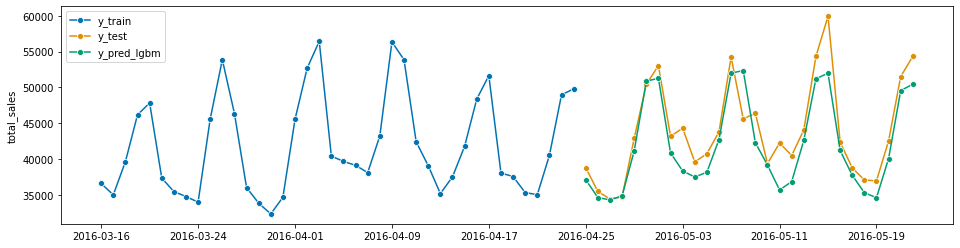

In [263]:
#prediction
y_pred_lgbm = lgb_gscv.predict(fh)

#Save model
save_model('lgbm')

# create a tunnable regressor with GridSearchCV
loss_lgbm=load_model('lgbm', y_train, y_test, y_pred_lgbm)

#Save and display model name with SMAPE loss 
myindex = result.shape[0]+1 
result.at[myindex,'model']='lgbm'
result.at[myindex,'smape_loss']=loss_lgbm
result[result['model']=='lgbm']

## XGBRegressor

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

In [264]:
%%time

xgb = XGBRegressor()

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))

#XGBM param grid
xgb_params_grid = {
 
    'learning_rate': [0.1, 0.01],
    'max_depth': [-1, 2, 5,],
    'n_estimators': [50, 100]
}

#GridsearchCV param grid
gscv_param_grid = {
    "window_length": [75, 80, 90]
}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(xgb, param_grid=xgb_params_grid)
                         
forecaster = ReducedForecaster(regressor,scitype='regressor')

xgb_gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=gscv_param_grid, scoring=sMAPE())
xgb_gscv.fit(y_train)
xgb_results = pd.DataFrame(xgb_gscv.cv_results_)

C:\Users\fast6\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fast6\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fast6\anaconda3\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Users\fast6\anaconda3\lib\site-packages\xgboost\sklearn.py", line 597, in fit
    self._Booster = train(params, train_dmatrix,
  File "C:\Users\fast6\anaconda3\lib\site-packages\xgboost\training.py", line 227, in train
    bst = _train_internal(params, dtrain,
  File "C:\Users\fast6\anaconda3\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Users\fast6\anaconda3\lib\site-packages\xgboost\

C:\Users\fast6\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fast6\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fast6\anaconda3\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Users\fast6\anaconda3\lib\site-packages\xgboost\sklearn.py", line 597, in fit
    self._Booster = train(params, train_dmatrix,
  File "C:\Users\fast6\anaconda3\lib\site-packages\xgboost\training.py", line 227, in train
    bst = _train_internal(params, dtrain,
  File "C:\Users\fast6\anaconda3\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Users\fast6\anaconda3\lib\site-packages\xgboost\

Wall time: 2min 30s


In [265]:
#print XGBM best params
print(xgb_gscv.best_params_, xgb_gscv.best_forecaster_.regressor_.best_params_)

{'window_length': 80} {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}


,model,smape_loss
12,xgb,0.067767


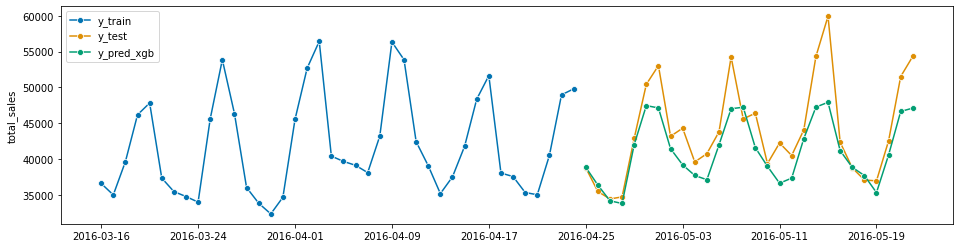

In [266]:
#prediction
y_pred_xgb = xgb_gscv.predict(fh)

#Save model
save_model('xgb')

#Plot and calculate SMAPE loss
loss_xgb=load_model('xgb', y_train, y_test, y_pred_xgb)

#Save and display model name with SMAPE loss
myindex = result.shape[0]+1 
result.at[myindex,'model']='xgb'
result.at[myindex,'smape_loss']=loss_xgb
result[result['model']=='xgb']

## SKtime Ensembler

Ensemble methods help improve machine learning results by combining multiple models. Using ensemble methods allows us to produce better predictions compared to a single model. 

C:\Users\fast6\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\fast6\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\fast6\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



,model,smape_loss
13,ensemble,0.063478


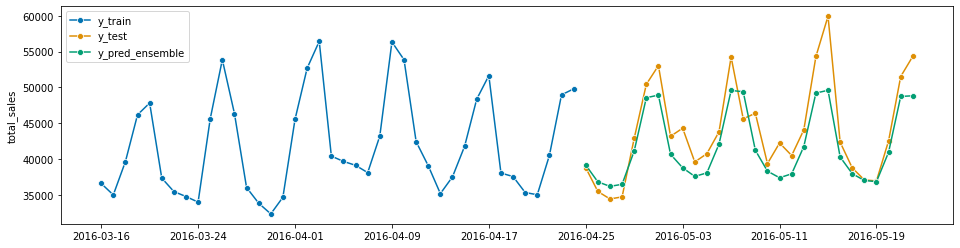

In [267]:
# sktime ensembler
forecaster = EnsembleForecaster([
        ('theta_ses', ThetaForecaster(sp=7)),
        ('theta', ThetaForecaster()),
        ("exp_ses", ExponentialSmoothing(seasonal="multiplicative", sp=7)),
        ("exp_damped", ExponentialSmoothing(trend='multiplicative', damped_trend=True, seasonal="multiplicative", sp=7)),
        ("bats", BATS(sp=7, use_trend=True, use_box_cox=False)),
        ("prophet",  Prophet(seasonality_mode='multiplicative', 
                        holidays=holidays,
                        n_changepoints=2,
                        changepoint_range=0.95,
                        changepoint_prior_scale=0.1,
                        seasonality_prior_scale=10,
                        holidays_prior_scale=10,
                        daily_seasonality=True, 
                        weekly_seasonality=True,
                        yearly_seasonality=True
                        )),
        ("lgbm", ReducedForecaster(LGBMRegressor(learning_rate = 0.1,
                            max_depth = -1, 
                            n_estimators = 50, 
                            num_leaves = 40),
                        scitype='regressor', 
                        window_length = 67
                            )),
        ("xgb", ReducedForecaster(XGBRegressor(learning_rate = 0.1,
                            max_depth = 2, 
                            n_estimators = 50),
                        scitype='regressor',
                        window_length = 80
                            )),
         ("r_forest", ReducedForecaster(RandomForestRegressor(n_estimators = 100), 
                             window_length=50, scitype='regressor',strategy="recursive"))
    ])

forecaster.fit(z_train)
y_pred = forecaster.predict(fh_p)
y_pred_es= y_pred.copy()
y_pred_es.index = y_pred.index.to_period()
smape_loss(y_test, y_pred_es)

save_model('ensemble')
loss_ensemble=load_model('ensemble', y_train, y_test, y_pred_es)

myindex = result.shape[0]+1 
result.at[myindex,'model']='ensemble'
result.at[myindex,'smape_loss']=loss_ensemble
result[result['model']=='ensemble']

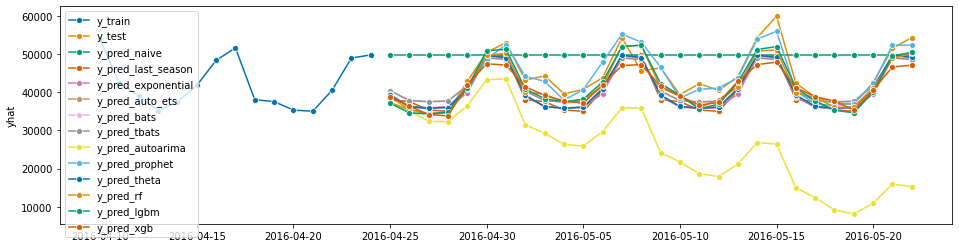

In [268]:
plot_series(y_train[-15:], y_test, y_pred_naive,y_pred_last_season, y_pred_exponential,y_pred_auto_ets,
            y_pred_bats,y_pred_tbats,y_pred_autoarima,y_pred_prophet,y_pred_theta,y_pred_rf,y_pred_lgbm,y_pred_xgb,
            labels=["y_train", "y_test", "y_pred_naive","y_pred_last_season", "y_pred_exponential", "y_pred_auto_ets", 
                    "y_pred_bats","y_pred_tbats", "y_pred_autoarima", "y_pred_prophet","y_pred_theta","y_pred_rf",
                    "y_pred_lgbm","y_pred_xgb"]);

In [269]:
result=result.sort_values('smape_loss',ignore_index=True)
#result=result.style.apply(highlight_max)
result.to_csv('../Dataset/results.csv')
result

,model,smape_loss
0,prophet,0.031872
1,lgbm,0.057895
2,r_forest,0.058013
3,ensemble,0.063478
4,xgb,0.067767
5,bats,0.070344
6,tbats,0.072434
7,theta,0.080372
8,auto_ets,0.081176
9,naive_last_season,0.087535
